<a href="https://colab.research.google.com/github/ShreyPandit/Lipschitz/blob/master/IRIS_RMSProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
!pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
iris=pd.read_csv("Iris.csv")

In [3]:
from sklearn.utils import shuffle
iris=shuffle(iris)
iris.pop('Id')
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
88,5.6,3.0,4.1,1.3,Iris-versicolor
30,4.8,3.1,1.6,0.2,Iris-setosa
25,5.0,3.0,1.6,0.2,Iris-setosa
113,5.7,2.5,5.0,2.0,Iris-virginica
137,6.4,3.1,5.5,1.8,Iris-virginica
...,...,...,...,...,...
64,5.6,2.9,3.6,1.3,Iris-versicolor
77,6.7,3.0,5.0,1.7,Iris-versicolor
67,5.8,2.7,4.1,1.0,Iris-versicolor
115,6.4,3.2,5.3,2.3,Iris-virginica


In [4]:
one_hot = pd.get_dummies(iris['Species'])

In [5]:
iris.pop('Species')

88     Iris-versicolor
30         Iris-setosa
25         Iris-setosa
113     Iris-virginica
137     Iris-virginica
            ...       
64     Iris-versicolor
77     Iris-versicolor
67     Iris-versicolor
115     Iris-virginica
74     Iris-versicolor
Name: Species, Length: 150, dtype: object

In [6]:
train_x=iris.iloc[0:125,:]

In [7]:
test_x=iris.iloc[125:,:]

In [8]:
train_y=one_hot.iloc[0:125,:]

In [9]:
test_y=one_hot.iloc[125:,:]

In [11]:
print(len(train_x),len(train_y),len(test_x),len(test_y))

125 125 25 25


In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_dim = 4 , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [13]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

Using TensorFlow backend.


In [32]:
lrs = []
K2 = 0.
beta2 = 0.9
batch_size=16
num_classes=3
from tqdm import tqdm

In [33]:
def lr_schedule(epoch):
    global K2

    Kz = 0.  # max penultimate activation
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in tqdm(range((len(train_x) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = train_x[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S + 2e-4 * max_wt * ((num_classes - 1) * Kz) / (num_classes * batch_size)
    
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / Kz
    print('S =', S, 'max_wt =', max_wt, 'Kz =', Kz, 'K2 =', K2, 'S_ =', S_)
    lrs.append(lr)
    print('Epoch', epoch+1, 'LR =', lr)
    return lr

In [34]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [35]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(lr=1e-3, decay=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [36]:
history=model.fit(train_x,train_y,batch_size=16,epochs=50,validation_data=(test_x,test_y),callbacks=[lr_scheduler])

Train on 125 samples, validate on 25 samples


100%|██████████| 8/8 [00:00<00:00, 801.64it/s]


S = 607.65857 max_wt = 3.5607178 Kz = 57.85122 K2 = 0.10566793928784857 S_ = 1.056679392878486
Epoch 1 LR = 0.0056190026477133245
Epoch 1/50
125/125 [==============================] - 0s 2ms/sample - loss: 1.1205 - acc: 0.3360 - val_loss: 0.9666 - val_acc: 0.4000


100%|██████████| 8/8 [00:00<00:00, 884.64it/s]

S = 607.65857 max_wt = 3.5353575 Kz = 57.85122 K2 = 0.20076786204114092 S_ = 1.0566671668207723
Epoch 2 LR = 0.007745236406476711
Epoch 2/50
125/125 [==============================] - 0s 166us/sample - loss: 1.0506 - acc: 0.3600 - val_loss: 0.9983 - val_acc: 0.9200



100%|██████████| 8/8 [00:00<00:00, 712.20it/s]

S = 607.65857 max_wt = 3.5391953 Kz = 57.85122 K2 = 0.28635797753809544 S_ = 1.0566690170106867
Epoch 3 LR = 0.009250010133791547
Epoch 3/50
125/125 [==============================] - 0s 152us/sample - loss: 0.9808 - acc: 0.4800 - val_loss: 0.8570 - val_acc: 0.6400



100%|██████████| 8/8 [00:00<00:00, 870.62it/s]

S = 607.65857 max_wt = 3.5955 Kz = 57.85122 K2 = 0.36339179589797815 S_ = 1.0566961611369226
Epoch 4 LR = 0.010420177461512045
Epoch 4/50
125/125 [==============================] - 0s 152us/sample - loss: 0.9296 - acc: 0.5600 - val_loss: 0.7972 - val_acc: 0.9200



100%|██████████| 8/8 [00:00<00:00, 1006.64it/s]

S = 607.65857 max_wt = 3.6417956 Kz = 57.85122 K2 = 0.4327244643046906 S_ = 1.0567184799651028
Epoch 5 LR = 0.011370859009848102
Epoch 5/50
125/125 [==============================] - 0s 158us/sample - loss: 0.8478 - acc: 0.5280 - val_loss: 0.6828 - val_acc: 0.9200



100%|██████████| 8/8 [00:00<00:00, 818.40it/s]

S = 607.65857 max_wt = 3.7150288 Kz = 57.85122 K2 = 0.4951273963921613 S_ = 1.0567537851793984
Epoch 6 LR = 0.012163148933243466
Epoch 6/50
125/125 [==============================] - 0s 152us/sample - loss: 0.8463 - acc: 0.5360 - val_loss: 0.7252 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 967.32it/s]


S = 607.65857 max_wt = 3.7201576 Kz = 57.85122 K2 = 0.5512902825299112 S_ = 1.05675625776966
Epoch 7 LR = 0.012834463265885094
Epoch 7/50
125/125 [==============================] - 0s 160us/sample - loss: 0.7919 - acc: 0.6240 - val_loss: 0.5985 - val_acc: 0.6000


100%|██████████| 8/8 [00:00<00:00, 879.72it/s]


S = 607.65857 max_wt = 3.8301055 Kz = 57.85122 K2 = 0.6018421805715604 S_ = 1.0568092629464023
Epoch 8 LR = 0.013410002267504625
Epoch 8/50
125/125 [==============================] - 0s 157us/sample - loss: 0.6612 - acc: 0.6320 - val_loss: 0.5124 - val_acc: 0.9200


100%|██████████| 8/8 [00:00<00:00, 946.26it/s]


S = 607.65857 max_wt = 3.9860222 Kz = 57.85122 K2 = 0.6473464054512565 S_ = 1.0568844293685222
Epoch 9 LR = 0.01390771903764328
Epoch 9/50
125/125 [==============================] - 0s 153us/sample - loss: 0.6429 - acc: 0.6320 - val_loss: 0.5311 - val_acc: 0.6000


100%|██████████| 8/8 [00:00<00:00, 985.85it/s]


S = 607.65857 max_wt = 4.1224484 Kz = 57.85122 K2 = 0.6883067848618161 S_ = 1.056950199556852
Epoch 10 LR = 0.014340971138001622
Epoch 10/50
125/125 [==============================] - 0s 188us/sample - loss: 0.6133 - acc: 0.6480 - val_loss: 0.4859 - val_acc: 0.6400


100%|██████████| 8/8 [00:00<00:00, 586.48it/s]

S = 607.65857 max_wt = 4.175631 Kz = 57.85122 K2 = 0.7251736902299535 S_ = 1.0569758385431902
Epoch 11 LR = 0.014720025242582622
Epoch 11/50
125/125 [==============================] - 0s 144us/sample - loss: 0.5806 - acc: 0.6800 - val_loss: 0.5110 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 946.42it/s]

S = 607.65857 max_wt = 4.256358 Kz = 57.85122 K2 = 0.7583577968622581 S_ = 1.0570147565530001
Epoch 12 LR = 0.015053053741165464
Epoch 12/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.5684 - acc: 0.8125

125/125 [==============================] - 0s 160us/sample - loss: 0.6211 - acc: 0.6880 - val_loss: 0.5295 - val_acc: 0.6000


100%|██████████| 8/8 [00:00<00:00, 998.73it/s]

S = 607.65857 max_wt = 4.2959914 Kz = 57.85122 K2 = 0.7882254035256868 S_ = 1.0570338634965453
Epoch 13 LR = 0.015346620254444714
Epoch 13/50
125/125 [==============================] - 0s 135us/sample - loss: 0.5575 - acc: 0.6800 - val_loss: 0.5295 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 752.58it/s]

S = 607.65857 max_wt = 4.3191867 Kz = 57.85122 K2 = 0.8151073677514886 S_ = 1.0570450457837044
Epoch 14 LR = 0.015606119985762236
Epoch 14/50
125/125 [==============================] - 0s 160us/sample - loss: 0.6545 - acc: 0.6800 - val_loss: 0.4779 - val_acc: 0.9600



100%|██████████| 8/8 [00:00<00:00, 903.51it/s]

S = 607.65857 max_wt = 4.4154077 Kz = 57.85122 K2 = 0.8393057743050717 S_ = 1.0570914332873196
Epoch 15 LR = 0.015836078177267704
Epoch 15/50
125/125 [==============================] - 0s 140us/sample - loss: 0.5631 - acc: 0.7040 - val_loss: 0.4856 - val_acc: 0.8400



100%|██████████| 8/8 [00:00<00:00, 949.50it/s]

S = 607.65857 max_wt = 4.497248 Kz = 57.85122 K2 = 0.8610882856812788 S_ = 1.0571308880671426
Epoch 16 LR = 0.01604025881475558
Epoch 16/50
125/125 [==============================] - 0s 158us/sample - loss: 0.5921 - acc: 0.6960 - val_loss: 0.4252 - val_acc: 0.8400



100%|██████████| 8/8 [00:00<00:00, 947.87it/s]


S = 607.65857 max_wt = 4.5772996 Kz = 57.85122 K2 = 0.8806964051468372 S_ = 1.057169480336863
Epoch 17 LR = 0.016221859748067852
Epoch 17/50
125/125 [==============================] - 0s 140us/sample - loss: 0.5942 - acc: 0.7040 - val_loss: 0.4159 - val_acc: 0.6800


100%|██████████| 8/8 [00:00<00:00, 907.05it/s]

S = 607.65857 max_wt = 4.688574 Kz = 57.85122 K2 = 0.8983490771246614 S_ = 1.0572231249250792
Epoch 18 LR = 0.01638362854550893
Epoch 18/50
125/125 [==============================] - 0s 146us/sample - loss: 0.6288 - acc: 0.6320 - val_loss: 0.4654 - val_acc: 0.9200



100%|██████████| 8/8 [00:00<00:00, 910.42it/s]

S = 607.65857 max_wt = 4.7071977 Kz = 57.85122 K2 = 0.9142373797473755 S_ = 1.0572321033518035
Epoch 19 LR = 0.016527874883135674
Epoch 19/50
125/125 [==============================] - 0s 138us/sample - loss: 0.5594 - acc: 0.6960 - val_loss: 0.5517 - val_acc: 0.7200



100%|██████████| 8/8 [00:00<00:00, 946.77it/s]

S = 607.65857 max_wt = 4.775308 Kz = 57.85122 K2 = 0.9285401356690658 S_ = 1.0572649389642788
Epoch 20 LR = 0.016656658029635625
Epoch 20/50
125/125 [==============================] - 0s 152us/sample - loss: 0.4899 - acc: 0.7680 - val_loss: 0.3641 - val_acc: 0.8800



100%|██████████| 8/8 [00:00<00:00, 1129.66it/s]


S = 607.65857 max_wt = 4.9388733 Kz = 57.85122 K2 = 0.9414205013684654 S_ = 1.0573437926630624
Epoch 21 LR = 0.016771787636946235
Epoch 21/50
125/125 [==============================] - 0s 157us/sample - loss: 1.1777 - acc: 0.6400 - val_loss: 0.3639 - val_acc: 0.8800


100%|██████████| 8/8 [00:00<00:00, 756.02it/s]

S = 607.65857 max_wt = 4.838533 Kz = 57.85122 K2 = 0.9530079931541529 S_ = 1.057295419225339
Epoch 22 LR = 0.016874689881508694
Epoch 22/50
125/125 [==============================] - 0s 157us/sample - loss: 0.6547 - acc: 0.6880 - val_loss: 0.4893 - val_acc: 0.7600



100%|██████████| 8/8 [00:00<00:00, 934.59it/s]

S = 607.65857 max_wt = 4.75883 Kz = 57.85122 K2 = 0.9634328933385341 S_ = 1.057256994997965
Epoch 23 LR = 0.01696673447504052
Epoch 23/50
125/125 [==============================] - 0s 148us/sample - loss: 0.4954 - acc: 0.7440 - val_loss: 0.5229 - val_acc: 0.6400



100%|██████████| 8/8 [00:00<00:00, 989.51it/s]

S = 607.65857 max_wt = 4.8026295 Kz = 57.85122 K2 = 0.9728174150450675 S_ = 1.0572781104038675
Epoch 24 LR = 0.017049168243635043
Epoch 24/50
125/125 [==============================] - 0s 146us/sample - loss: 0.5383 - acc: 0.7520 - val_loss: 0.5518 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 807.98it/s]

S = 607.65857 max_wt = 4.8250794 Kz = 57.85122 K2 = 0.9812645668794051 S_ = 1.057288933388444
Epoch 25 LR = 0.017123028772187018
Epoch 25/50
125/125 [==============================] - 0s 180us/sample - loss: 0.4450 - acc: 0.8240 - val_loss: 0.3353 - val_acc: 0.9600



100%|██████████| 8/8 [00:00<00:00, 899.41it/s]

S = 607.65857 max_wt = 4.996826 Kz = 57.85122 K2 = 0.988875283328448 S_ = 1.0573717313698336
Epoch 26 LR = 0.017189303859788223
Epoch 26/50
125/125 [==============================] - 0s 166us/sample - loss: 0.4646 - acc: 0.8240 - val_loss: 0.5199 - val_acc: 0.7200



100%|██████████| 8/8 [00:00<00:00, 910.27it/s]

S = 607.65857 max_wt = 5.0238786 Kz = 57.85122 K2 = 0.9957262323113083 S_ = 1.057384773157051
Epoch 27 LR = 0.01724874501037275
Epoch 27/50
125/125 [==============================] - 0s 151us/sample - loss: 0.5558 - acc: 0.7280 - val_loss: 0.6238 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 958.73it/s]

S = 607.65857 max_wt = 5.099352 Kz = 57.85122 K2 = 1.001895724914979 S_ = 1.0574211583480153
Epoch 28 LR = 0.017302098864925168
Epoch 28/50
125/125 [==============================] - 0s 152us/sample - loss: 0.4457 - acc: 0.8240 - val_loss: 0.2829 - val_acc: 1.0000



100%|██████████| 8/8 [00:00<00:00, 951.20it/s]

S = 607.65857 max_wt = 5.218618 Kz = 57.85122 K2 = 1.007454017996137 S_ = 1.057478655726561
Epoch 29 LR = 0.017350026563658572
Epoch 29/50
125/125 [==============================] - 0s 145us/sample - loss: 0.5174 - acc: 0.7840 - val_loss: 0.7206 - val_acc: 0.6000



100%|██████████| 8/8 [00:00<00:00, 907.37it/s]

S = 607.65857 max_wt = 5.212309 Kz = 57.85122 K2 = 1.0124561776148306 S_ = 1.0574756141830735
Epoch 30 LR = 0.01739304596223238
Epoch 30/50
125/125 [==============================] - 0s 152us/sample - loss: 0.5301 - acc: 0.7920 - val_loss: 0.2814 - val_acc: 0.9600



100%|██████████| 8/8 [00:00<00:00, 905.73it/s]

S = 607.65857 max_wt = 5.3764896 Kz = 57.85122 K2 = 1.0169660363190531 S_ = 1.0575547646570551
Epoch 31 LR = 0.017431740484127902
Epoch 31/50
125/125 [==============================] - 0s 145us/sample - loss: 0.5879 - acc: 0.7360 - val_loss: 0.2844 - val_acc: 0.9600



100%|██████████| 8/8 [00:00<00:00, 973.35it/s]


S = 607.65857 max_wt = 5.3707504 Kz = 57.85122 K2 = 1.0210246324691754 S_ = 1.0575519978202765
Epoch 32 LR = 0.017466489894915917
Epoch 32/50
125/125 [==============================] - 0s 158us/sample - loss: 0.4854 - acc: 0.8080 - val_loss: 0.2403 - val_acc: 0.9600


100%|██████████| 8/8 [00:00<00:00, 995.62it/s]

S = 607.65857 max_wt = 5.4982285 Kz = 57.85122 K2 = 1.0246835146416333 S_ = 1.0576134541937539
Epoch 33 LR = 0.01749775783324047
Epoch 33/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.4392 - acc: 0.8125

125/125 [==============================] - 0s 157us/sample - loss: 0.4497 - acc: 0.8160 - val_loss: 0.3606 - val_acc: 0.9200


100%|██████████| 8/8 [00:00<00:00, 1028.36it/s]

S = 607.65857 max_wt = 5.5159235 Kz = 57.85122 K2 = 1.027977361658876 S_ = 1.0576219848140604
Epoch 34 LR = 0.01752585855328056
Epoch 34/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.6674 - acc: 0.7500

125/125 [==============================] - 0s 154us/sample - loss: 0.4882 - acc: 0.8080 - val_loss: 0.4562 - val_acc: 0.7600


100%|██████████| 8/8 [00:00<00:00, 1021.60it/s]

S = 607.65857 max_wt = 5.5281196 Kz = 57.85122 K2 = 1.0309424119387038 S_ = 1.0576278644571546
Epoch 35 LR = 0.0175511157384915
Epoch 35/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.5103 - acc: 0.8125

125/125 [==============================] - 0s 165us/sample - loss: 0.4500 - acc: 0.8160 - val_loss: 0.4588 - val_acc: 0.7600


100%|██████████| 8/8 [00:00<00:00, 706.54it/s]


S = 607.65857 max_wt = 5.5713243 Kz = 57.85122 K2 = 1.0336130400650918 S_ = 1.0576486932025833
Epoch 36 LR = 0.017573833875777496
Epoch 36/50
125/125 [==============================] - 0s 178us/sample - loss: 0.5895 - acc: 0.7680 - val_loss: 0.2529 - val_acc: 1.0000


100%|██████████| 8/8 [00:00<00:00, 963.40it/s]


S = 607.65857 max_wt = 5.6480837 Kz = 57.85122 K2 = 1.036020305896598 S_ = 1.0576856983801537
Epoch 37 LR = 0.01759428654076608
Epoch 37/50
125/125 [==============================] - 0s 228us/sample - loss: 0.3437 - acc: 0.8800 - val_loss: 0.5230 - val_acc: 0.7600


100%|██████████| 8/8 [00:00<00:00, 955.18it/s]

S = 607.65857 max_wt = 5.7211156 Kz = 57.85122 K2 = 1.0381903659654432 S_ = 1.0577209065850508
Epoch 38 LR = 0.017612703497555227
Epoch 38/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.5870 - acc: 0.7500

125/125 [==============================] - 0s 158us/sample - loss: 0.6432 - acc: 0.7040 - val_loss: 0.4171 - val_acc: 0.8800


100%|██████████| 8/8 [00:00<00:00, 959.36it/s]

S = 607.65857 max_wt = 5.7136335 Kz = 57.85122 K2 = 1.0401430593225527 S_ = 1.057717299536539
Epoch 39 LR = 0.017629259251831984
Epoch 39/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.7323 - acc: 0.7500

125/125 [==============================] - 0s 171us/sample - loss: 0.5098 - acc: 0.8000 - val_loss: 0.2499 - val_acc: 0.9600


100%|██████████| 8/8 [00:00<00:00, 1033.30it/s]

S = 607.65857 max_wt = 5.779414 Kz = 57.85122 K2 = 1.0419036545857863 S_ = 1.0577490119548882
Epoch 40 LR = 0.017644173000486502
Epoch 40/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.4527 - acc: 0.6875

125/125 [==============================] - 0s 155us/sample - loss: 0.4032 - acc: 0.8240 - val_loss: 0.2201 - val_acc: 0.9600


100%|██████████| 8/8 [00:00<00:00, 936.10it/s]

S = 607.65857 max_wt = 5.824905 Kz = 57.85122 K2 = 1.043490383401755 S_ = 1.0577709427454745
Epoch 41 LR = 0.017657603159748875
Epoch 41/50
 16/125 [==>...........................] - ETA: 0s - loss: 0.3307 - acc: 0.8750

125/125 [==============================] - 0s 163us/sample - loss: 0.6435 - acc: 0.7680 - val_loss: 0.4284 - val_acc: 0.8000


100%|██████████| 8/8 [00:00<00:00, 996.21it/s]

S = 607.65857 max_wt = 5.8038654 Kz = 57.85122 K2 = 1.0449174250362003 S_ = 1.0577607997462077
Epoch 42 LR = 0.01766967299942728
Epoch 42/50
125/125 [==============================] - 0s 155us/sample - loss: 0.4518 - acc: 0.8320 - val_loss: 0.3095 - val_acc: 0.9200



100%|██████████| 8/8 [00:00<00:00, 829.96it/s]


S = 607.65857 max_wt = 5.8698974 Kz = 57.85122 K2 = 1.0462049458637168 S_ = 1.0577926333113652
Epoch 43 LR = 0.01768055570916622
Epoch 43/50
125/125 [==============================] - 0s 145us/sample - loss: 0.4992 - acc: 0.8240 - val_loss: 0.2119 - val_acc: 0.9600


100%|██████████| 8/8 [00:00<00:00, 916.36it/s]

S = 607.65857 max_wt = 5.8519015 Kz = 57.85122 K2 = 1.0473628470410172 S_ = 1.0577839576367212
Epoch 44 LR = 0.017690337097113238
Epoch 44/50
125/125 [==============================] - 0s 147us/sample - loss: 0.4954 - acc: 0.7840 - val_loss: 0.2434 - val_acc: 0.9600



100%|██████████| 8/8 [00:00<00:00, 857.49it/s]

S = 607.65857 max_wt = 5.8784018 Kz = 57.85122 K2 = 1.0484062356591948 S_ = 1.0577967332227929
Epoch 45 LR = 0.017699146508269918
Epoch 45/50
125/125 [==============================] - 0s 148us/sample - loss: 0.3024 - acc: 0.9120 - val_loss: 0.1750 - val_acc: 1.0000



100%|██████████| 8/8 [00:00<00:00, 876.96it/s]

S = 607.65857 max_wt = 5.9480686 Kz = 57.85122 K2 = 1.0493486440096638 S_ = 1.057830319163886
Epoch 46 LR = 0.017707099568160304
Epoch 46/50
125/125 [==============================] - 0s 148us/sample - loss: 0.5060 - acc: 0.8080 - val_loss: 0.3506 - val_acc: 0.8800



100%|██████████| 8/8 [00:00<00:00, 907.51it/s]


S = 607.65857 max_wt = 5.938169 Kz = 57.85122 K2 = 1.0501963342710285 S_ = 1.0578255466233113
Epoch 47 LR = 0.017714250244112467
Epoch 47/50
125/125 [==============================] - 0s 175us/sample - loss: 0.4283 - acc: 0.8320 - val_loss: 0.1993 - val_acc: 0.9600


100%|██████████| 8/8 [00:00<00:00, 941.17it/s]


S = 607.65857 max_wt = 5.9886737 Kz = 57.85122 K2 = 1.0509616903042314 S_ = 1.057849894603057
Epoch 48 LR = 0.017720703912491156
Epoch 48/50
125/125 [==============================] - 0s 175us/sample - loss: 0.4336 - acc: 0.8320 - val_loss: 0.1858 - val_acc: 1.0000


100%|██████████| 8/8 [00:00<00:00, 1016.55it/s]


S = 607.65857 max_wt = 6.025325 Kz = 57.85122 K2 = 1.0516522776614594 S_ = 1.0578675638765116
Epoch 49 LR = 0.017726525096704755
Epoch 49/50
125/125 [==============================] - 0s 194us/sample - loss: 0.4374 - acc: 0.8080 - val_loss: 0.1828 - val_acc: 1.0000


100%|██████████| 8/8 [00:00<00:00, 996.48it/s]

S = 607.65857 max_wt = 6.0454044 Kz = 57.85122 K2 = 1.052274774308029 S_ = 1.0578772441271544
Epoch 50 LR = 0.017731770684598896
Epoch 50/50
125/125 [==============================] - 0s 159us/sample - loss: 0.4714 - acc: 0.8240 - val_loss: 0.2195 - val_acc: 0.9600


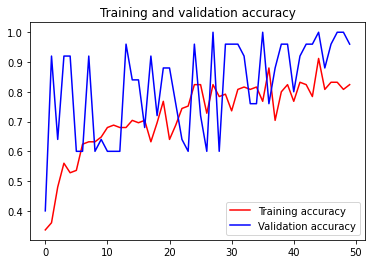

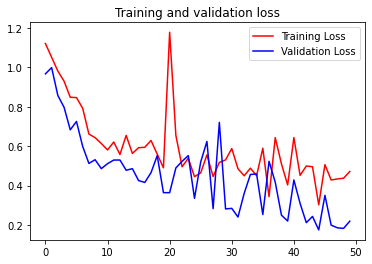

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()